## Skin Cancer Detection with CNNs

### Using a pre-trained convnet
A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes), and use this to do binary classification of benign and malignant images.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet.

### Importing Libraries

In [60]:
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam,SGD,RMSprop
import os
from os import listdir, makedirs, getcwd, remove
import numpy as np
import pandas as pd
import glob2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import os
import scipy
import skimage
from skimage.transform import resize
import glob
import h5py
import shutil
import seaborn as sns
import cv2
import random as rn
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline

In [61]:
print(os.listdir('C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/data'))

['test', 'train', 'val']


In [62]:
# here we have checked type of our images in our dataset.
#Since we are inputting 3 channels in our model so,images in our dataset must have 3 channels i.e.,RGB images.
img = cv2.imread('C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/data/train/benign/25.jpg')
print(img.shape)

(224, 224, 3)


#### Visualisation of Dataset

benign


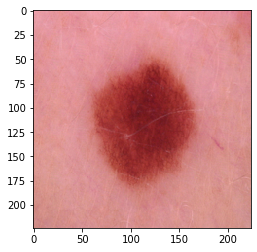

In [63]:
img_name = '17.jpg'
img_benign = load_img('C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/data/train/benign/' + img_name)
print('benign')
plt.imshow(img_benign)
plt.show()


malignant


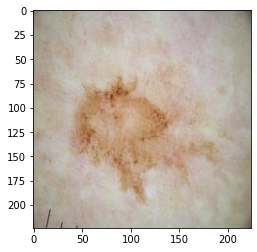

In [64]:
img_name = '69.jpg'
img_malignant = load_img('C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/data/train/malignant/'+ img_name)
print('malignant')
plt.imshow(img_malignant)
plt.show()


In [65]:
img_width, img_height = 120,120
training_dir='C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/data/train'
validation_dir='C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/data/val'
testing_dir='C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/data/test'

In [66]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height,3)

#### Data Augmentation and Normalisation to prevent overfitting

In [67]:
batch_size=10
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 2709 images belonging to 2 classes.


In [68]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 48 images belonging to 2 classes.


In [69]:
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 540 images belonging to 2 classes.


#### Importing VGG-16 model

In [125]:
from keras.applications.vgg16 import VGG16
base_model=VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3),pooling='avg')

In [126]:

base_model.summary()
print(len(base_model.layers))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

#### Fine Tunning of last block in VGG-16 model

In [127]:

model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))


for layer in base_model.layers[:15]:
    layer.trainable=False
for layer in base_model.layers[15:]:
    layer.trainable=True

model.summary()
model.compile(optimizer=Adam(lr=2e-5),loss='binary_crossentropy',metrics=['accuracy'])


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 14,847,297
Trainable params: 7,211,521
Non-trainable params: 7,635,776
_________________________________________________________________


In [128]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=300,
    validation_data=validation_generator,validation_steps=10)

Epoch 1/300
10/10 [==============================] - 5s 515ms/step - loss: 0.7441 - accuracy: 0.5200 - val_loss: 0.6329 - val_accuracy: 0.6667
Epoch 2/300
10/10 [==============================] - 5s 453ms/step - loss: 0.5331 - accuracy: 0.7500 - val_loss: 0.6541 - val_accuracy: 0.6875
Epoch 3/300
10/10 [==============================] - 5s 458ms/step - loss: 0.5252 - accuracy: 0.7700 - val_loss: 0.6457 - val_accuracy: 0.7083
Epoch 4/300
10/10 [==============================] - 5s 458ms/step - loss: 0.4760 - accuracy: 0.7900 - val_loss: 0.5616 - val_accuracy: 0.7292
Epoch 5/300
10/10 [==============================] - 5s 457ms/step - loss: 0.5368 - accuracy: 0.7300 - val_loss: 0.5491 - val_accuracy: 0.7500
Epoch 6/300
10/10 [==============================] - 5s 458ms/step - loss: 0.4402 - accuracy: 0.8000 - val_loss: 0.5821 - val_accuracy: 0.8125
Epoch 7/300
10/10 [==============================] - 5s 458ms/step - loss: 0.4530 - accuracy: 0.8300 - val_loss: 0.5504 - val_accuracy: 0.8125

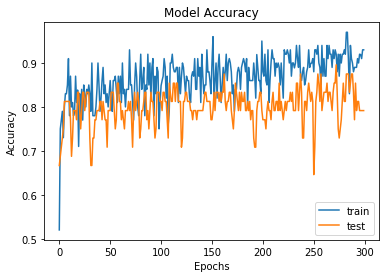

In [129]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

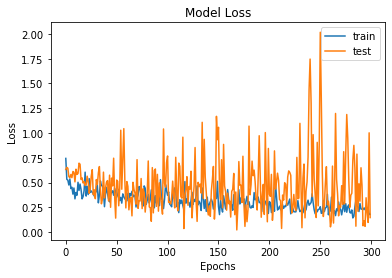

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Evaluation of model

In [131]:
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 85.56%


#### Preparing test dataset

In [132]:
x_test=[]
y_test=[]
benign_test_dir='C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/test/benign'
malignant_test_dir='C:/Users/Abhishek Gupta/Desktop/cancer_dataset/174469_505351_bundle_archive/test/malignant'


In [133]:
from tqdm import tqdm
IMG_SIZE= 120
def locate_label(img,img_typ):
    return img_typ

def test_data(img_typ,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=locate_label(img,img_typ)
        path=os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        x_test.append(np.array(img))
        y_test.append((label))

In [134]:

test_data('0',benign_test_dir)
print(len(x_test))

100%|██████████| 360/360 [00:00<00:00, 526.94it/s]

360


In [135]:
test_data('1',malignant_test_dir)
print(len(x_test))

100%|██████████| 300/300 [00:00<00:00, 660.24it/s]

660


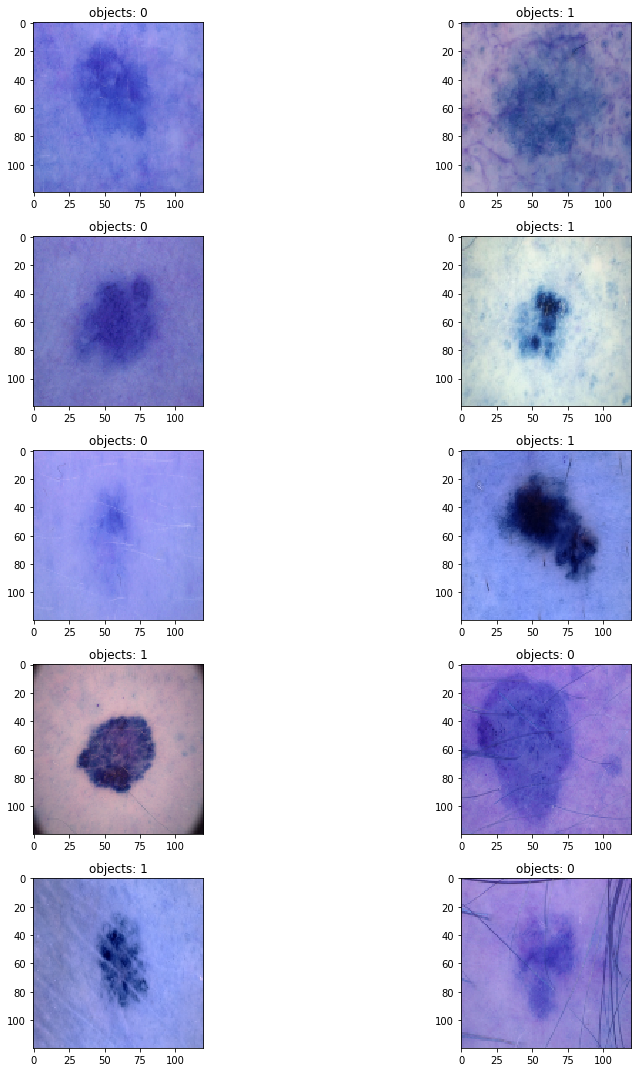

In [136]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_test))
        ax[i,j].imshow(x_test[l])
        ax[i,j].set_title('objects: '+y_test[l])
        
plt.tight_layout()

In [140]:
e=LabelEncoder()
original_labels=e.fit_transform(y_test)
print(original_labels)
original_labels=original_labels.reshape(660,1)
print(original_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [137]:
le=LabelEncoder()
Z=le.fit_transform(y_test)
Z=to_categorical(Z,2)
x_test=np.array(x_test)
x_test=x_test/255
print(Z)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


#### Predictions and other scores for evaluation and accuracy

In [138]:
y_pred = model.predict_classes(x_test)

print(accuracy_score(np.argmax(Z, axis=1),y_pred))

0.8363636363636363


In [139]:
preds = model.predict_classes(x_test, batch_size=10)
print(preds)
preds=preds.reshape(660,)
#preds = np.argmax(preds, axis=0)

# Original labels
#orig_test_labels = np.argmax(Z, axis=-1)

#print(orig_test_labels.shape)
print(preds.shape)
#print(preds)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]


<Figure size 432x288 with 0 Axes>

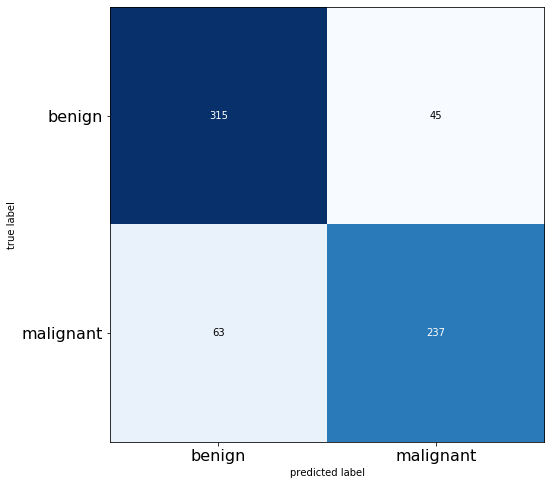

In [141]:
cm  = confusion_matrix(original_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['benign', 'malignant'], fontsize=16)
plt.yticks(range(2), ['benign', 'malignant'], fontsize=16)
plt.show()

In [142]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.79
Precision of the model is 0.84


In [143]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(original_labels, preds, target_names = ['malignant (Class 1)','benign (Class 0)']))

                     precision    recall  f1-score   support

malignant (Class 1)       0.83      0.88      0.85       360
   benign (Class 0)       0.84      0.79      0.81       300

           accuracy                           0.84       660
          macro avg       0.84      0.83      0.83       660
       weighted avg       0.84      0.84      0.84       660



In [ ]:
del model
K.clear_session()